In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cdist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
movie = '/content/drive/My Drive/dataset/movies_metadata.csv'
movie_df = pd.read_csv(movie)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
movie_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie_df['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [ ]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

# Create Movie Profile


#### Data Preprocessing

In [ ]:
import re
# drop unwanted columns
movie_df.drop(columns=['adult','budget','homepage','imdb_id','original_language','release_date','poster_path','production_companies','production_countries','release_date','revenue','runtime','spoken_languages','status','title','video','vote_count','popularity','belongs_to_collection'],inplace=True)
# remove NA values
movie_df = movie_df[movie_df["tagline"].str.contains("NaN") == False]
# 
movie_features = ["genres","overview","tagline"]
# combine these features, cleaning the content of the feature
def combined_features(row):
 return row['genres'] + " " + row['overview'] + " " + row['tagline'] + " " + row['original_title']
for feature in movie_features:
  movie_df[feature] = movie_df[feature].str.replace(r'[^\w\s]+', '').str.replace(r'[\d]+', '').str.replace('name', '').str.replace('id', '').str.replace(r'[\s]+', ' ').str.lower()
  movie_df[feature] = movie_df[feature].fillna('')
movie_df['combined_features'] = movie_df.apply(combined_features, axis=1)


<ipython-input-8-9155261ae29e>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  movie_df[feature] = movie_df[feature].str.replace(r'[^\w\s]+', '').str.replace(r'[\d]+', '').str.replace('name', '').str.replace('id', '').str.replace(r'[\s]+', ' ').str.lower()


In [ ]:
movie_df.shape

(20412, 7)

In [ ]:
movie_df.head()

,genres,id,original_title,overview,tagline,vote_average,combined_features
1,adventure fantasy family,8844,Jumanji,when siblings judy and peter discover an encha...,roll the dice and unleash the excitement,6.9,adventure fantasy family when siblings judy a...
2,romance comedy,15602,Grumpier Old Men,a family wedding reignites the ancient feud be...,still yelling still fighting still ready for love,6.5,romance comedy a family wedding reignites the...
3,comedy drama romance,31357,Waiting to Exhale,cheated on mistreated and stepped on the women...,friends are the people who let you be yourself...,6.1,comedy drama romance cheated on mistreated an...
4,comedy,11862,Father of the Bride Part II,just when george banks has recovered from his ...,just when his world is back to normal hes in f...,5.7,comedy just when george banks has recovered f...
5,action crime drama thriller,949,Heat,obsessive master thief neil mccauley leads a t...,a los angeles crime saga,7.7,action crime drama thriller obsessive master ...


In [ ]:
movie_df['combined_features'] = movie_df['combined_features'].str.strip()
movie_df['combined_features'] = movie_df['combined_features'].fillna("").astype('str')

movie_df.head()

,genres,id,original_title,overview,tagline,vote_average,combined_features
1,adventure fantasy family,8844,Jumanji,when siblings judy and peter discover an encha...,roll the dice and unleash the excitement,6.9,adventure fantasy family when siblings judy an...
2,romance comedy,15602,Grumpier Old Men,a family wedding reignites the ancient feud be...,still yelling still fighting still ready for love,6.5,romance comedy a family wedding reignites the ...
3,comedy drama romance,31357,Waiting to Exhale,cheated on mistreated and stepped on the women...,friends are the people who let you be yourself...,6.1,comedy drama romance cheated on mistreated and...
4,comedy,11862,Father of the Bride Part II,just when george banks has recovered from his ...,just when his world is back to normal hes in f...,5.7,comedy just when george banks has recovered fr...
5,action crime drama thriller,949,Heat,obsessive master thief neil mccauley leads a t...,a los angeles crime saga,7.7,action crime drama thriller obsessive master t...


In [ ]:
movie_df["combined_features"]

1        adventure fantasy family when siblings judy an...
2        romance comedy a family wedding reignites the ...
3        comedy drama romance cheated on mistreated and...
4        comedy just when george banks has recovered fr...
5        action crime drama thriller obsessive master t...
                               ...                        
45454    comedy drama the morning after is a feature fi...
45456    horror mystery thriller an unsuccessful sculpt...
45458    horror a film archivist revisits the story of ...
45461    drama family rising and falling between a man ...
45463    action drama thriller when one of her hits goe...
Name: combined_features, Length: 20412, dtype: object

#### Convert to TF-IDF

In [ ]:
# prepare stopwords
with open('/content/drive/My Drive/dataset/stopwords-english') as f:
    stopwords = f.read().splitlines()

print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(stop_words= 'english')
tfidf = tf.fit_transform(movie_df['combined_features'])
tfidf.shape

(20412, 60077)

In [ ]:
print(tfidf)

  (0, 27737)	0.23420120866018945
  (0, 17328)	0.15033560298500012
  (0, 55192)	0.1609777490130085
  (0, 13746)	0.2024664031704977
  (0, 44669)	0.15063098544784984
  (0, 11511)	0.1367824746790146
  (0, 52432)	0.1270186881672357
  (0, 34500)	0.2055231802090219
  (0, 17207)	0.09756661015545884
  (0, 44135)	0.2249193730706147
  (0, 20978)	0.13388862945465543
  (0, 45100)	0.131448138242783
  (0, 44366)	0.17298507042853897
  (0, 41487)	0.13521392817596314
  (0, 18738)	0.15004398345850337
  (0, 19767)	0.1282152077951533
  (0, 24440)	0.11738628181742185
  (0, 1248)	0.23420120866018945
  (0, 44773)	0.12832714847421173
  (0, 30652)	0.10006975899916422
  (0, 58531)	0.0828703232332887
  (0, 26104)	0.12059264655824871
  (0, 53828)	0.12489474512408269
  (0, 57633)	0.11882197625217425
  (0, 821)	0.14442008824785516
  :	:
  (20410, 44355)	0.5398365262311212
  (20410, 17962)	0.46388821047243567
  (20410, 58010)	0.2856518633295627
  (20410, 31954)	0.2409810425704696
  (20410, 14978)	0.07219798921597269


#### *Manhattan_distance*

In [ ]:
manhattan = 1 - pairwise_distances(tfidf, metric = "manhattan")
manhattan

array([[  1.        , -10.76941057, -10.41708325, ...,  -9.0241912 ,
         -7.55351053,  -8.92685894],
       [-10.76941057,   1.        , -10.09475529, ...,  -9.09194438,
         -7.45605016,  -9.21214286],
       [-10.41708325, -10.09475529,   1.        , ...,  -8.30771102,
         -6.57384959,  -8.34115491],
       ...,
       [ -9.0241912 ,  -9.09194438,  -8.30771102, ...,   1.        ,
         -5.57823666,  -7.2007581 ],
       [ -7.55351053,  -7.45605016,  -6.57384959, ...,  -5.57823666,
          1.        ,  -5.55403917],
       [ -8.92685894,  -9.21214286,  -8.34115491, ...,  -7.2007581 ,
         -5.55403917,   1.        ]])

In [ ]:
titles = movie_df['original_title']
indices = pd.Series(movie_df.reset_index().index, index=movie_df['original_title'])
indices

original_title
Jumanji                            0
Grumpier Old Men                   1
Waiting to Exhale                  2
Father of the Bride Part II        3
Heat                               4
                               ...  
The Morning After              20407
House of Horrors               20408
The Burkittsville 7            20409
رگ خواب                        20410
Betrayal                       20411
Length: 20412, dtype: int64

Chebyshev and Jaccard
 

#### Implementation and Results

In [ ]:
def Manhattan_recommendations(movie_title, sim = manhattan):
    movie_id = indices[movie_title]
    global sim_scores
    sim_scores = list(enumerate(sim[movie_id]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movie_df['original_title'].iloc[movie_indices]

In [ ]:
Manhattan_recommendations("John Wick")

26923                   Python 2
35314                 Tupla-Uuno
20621            The Wayward Bus
24953             Too Many Cooks
41954            Cuerpo de élite
23460    The Cabinet of Caligari
37547                    Fraktus
26024                        Gun
6889         Trapped in Paradise
40166                      P & B
Name: original_title, dtype: object

In [ ]:
Manhattan_recommendations("The Dark Knight")

26923                   Python 2
35314                 Tupla-Uuno
24953             Too Many Cooks
16318                 Mickey One
20621            The Wayward Bus
41954            Cuerpo de élite
23460    The Cabinet of Caligari
37547                    Fraktus
40166                      P & B
45461                    رگ خواب
Name: original_title, dtype: object

In [ ]:
Manhattan_recommendations("Shutter Island")

26923                   Python 2
35314                 Tupla-Uuno
37929                     Rumble
24953             Too Many Cooks
20621            The Wayward Bus
41954            Cuerpo de élite
23460    The Cabinet of Caligari
37547                    Fraktus
40166                      P & B
16318                 Mickey One
Name: original_title, dtype: object

In [ ]:
Manhattan_recommendations("Braveheart")

26923                   Python 2
35314                 Tupla-Uuno
24953             Too Many Cooks
37547                    Fraktus
20621            The Wayward Bus
41954            Cuerpo de élite
20767             E Aí... Comeu?
40166                      P & B
23460    The Cabinet of Caligari
16318                 Mickey One
Name: original_title, dtype: object

In [ ]:
Manhattan_recommendations("La La Land")

26923           Python 2
35314         Tupla-Uuno
24953     Too Many Cooks
39719            La nona
37547            Fraktus
20767     E Aí... Comeu?
20621    The Wayward Bus
41954    Cuerpo de élite
28938       Ballermann 6
40166              P & B
Name: original_title, dtype: object

In [ ]:
Manhattan_recommendations("Harry Potter and the Philosopher's Stone")

26923                                   Python 2
35314                                 Tupla-Uuno
24953                             Too Many Cooks
20621                            The Wayward Bus
5678     Harry Potter and the Chamber of Secrets
41954                            Cuerpo de élite
37547                                    Fraktus
23460                    The Cabinet of Caligari
40166                                      P & B
3933                             The Amati Girls
Name: original_title, dtype: object

In [ ]:
Manhattan_recommendations("Intouchables")

26923                   Python 2
35314                 Tupla-Uuno
24953             Too Many Cooks
41954            Cuerpo de élite
20621            The Wayward Bus
37547                    Fraktus
40166                      P & B
35110              The Big Short
20767             E Aí... Comeu?
23460    The Cabinet of Caligari
Name: original_title, dtype: object

In [ ]:
Manhattan_recommendations("TRON: Legacy")

26923                   Python 2
35314                 Tupla-Uuno
1996                        Tron
24953             Too Many Cooks
20621            The Wayward Bus
16318                 Mickey One
41954            Cuerpo de élite
37547                    Fraktus
20767             E Aí... Comeu?
23460    The Cabinet of Caligari
Name: original_title, dtype: object

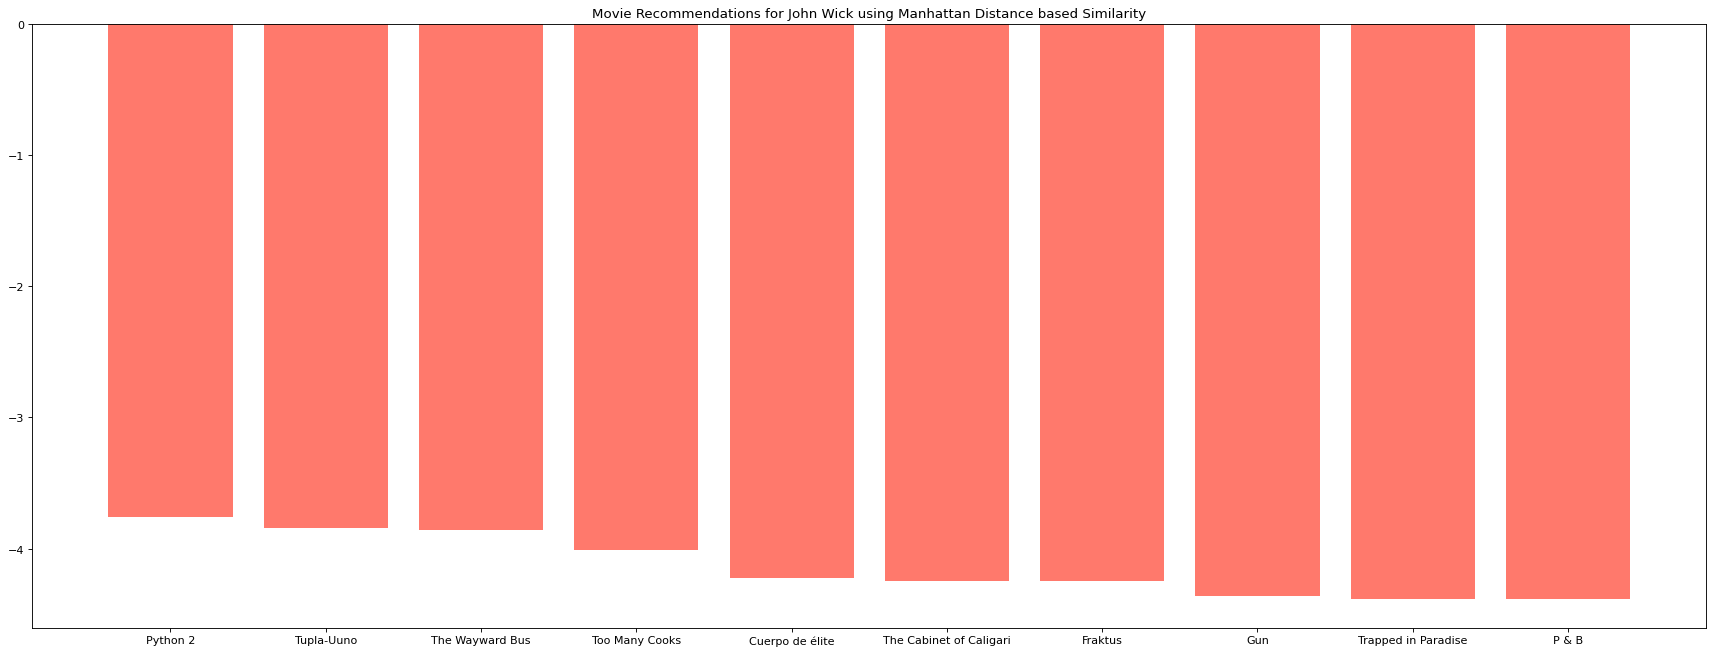

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(27, 10), dpi=80)
movie_indices = [i[0] for i in sim_scores]
raw_score = []
for element in sim_scores:
  raw_score.append(element[1])


x = np.array(movie_df['original_title'].iloc[movie_indices])
y = np.array(raw_score)


plt.bar(x,y, color = "#FF796C")
plt.title("Movie Recommendations for John Wick using Manhattan Distance based Similarity")
plt.show()